<a href="https://colab.research.google.com/github/m-evdokimov/dls-image-classification/blob/main/vit_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification (ViT, part 1)

## Dataset: CIFAR10

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='/content/cifar10_train', train=True, download=True)
test_data = torchvision.datasets.CIFAR10(root='/content/cifar10_test', train=False, download=True)

In [ ]:
labels = {0: 'airplane',
          1: 'automobile',
          2: 'bird',
          3: 'cat',
          4: 'deer',
          5: 'dog',
          6: 'frog',
          7: 'horse',
          8: 'ship',
          9: 'truck'}

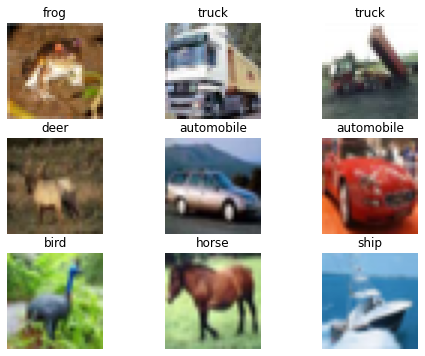

In [ ]:
random_idx = np.random.randint(1, len(train_data), size=9)
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for idx, ax in enumerate(axes.ravel()):
    img = train_data[idx][0]
    ax.set_title(labels[train_data[idx][1]])
    ax.axis('off')
    ax.imshow(img)

#Pretrained VIT

**Fine-tuning is in part 2 notebook**

In [ ]:
!pip install transformers

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
vit_model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10').to(device)

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='/content/cifar10_train', train=True, download=True)
test_data = torchvision.datasets.CIFAR10(root='/content/cifar10_test', train=False, download=True)

In [ ]:
def vit_collate_fn(data):
  global feature_extractor
  batch_size = len(data)
  inputs = feature_extractor([x[0] for x in data], return_tensors='pt')['pixel_values']
  labels = []
  for i in range(batch_size):
    labels.append(data[i][1])
  return inputs, torch.IntTensor(labels)

In [ ]:
def evaluate_vit(model, test_dataloader):
  global device
  model.eval()
  test_acc = 0
  test_size = 0

  with torch.no_grad():
    
    for batch in tqdm.tqdm(test_dataloader, position=0, leave=True):
      inputs = batch[0].to(device)
      labels = batch[1]

      output = model(inputs)['logits']
      pred_labels = torch.argmax(output, dim=-1)
      test_acc += (labels == pred_labels.cpu()).sum()
      test_size += int(labels.shape[0])
  print()
  print(test_acc / float(test_size))

batch_size = 64
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=vit_collate_fn, drop_last=False)
evaluate_vit(vit_model, test_dataloader)

100%|██████████| 157/157 [04:13<00:00,  1.61s/it]


tensor(0.9852)


# Pretrained CNN

Pretrained CNN is taken from the [repo](https://github.com/huyvnphan/PyTorch_CIFAR10)



In [ ]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git
!pip install pytorch_lightning
!python /content/PyTorch_CIFAR10/train.py --download_weights 1

In [ ]:
!cp -r /content/cifar10_models/state_dicts /content/PyTorch_CIFAR10/cifar10_models

In [ ]:
with open('/content/PyTorch_CIFAR10/cifar10_models/vgg.py') as file:
  exec(file.read())

In [ ]:
cnn_model = vgg11_bn(pretrained=True)

In [ ]:
test_data = torchvision.datasets.CIFAR10(root='/content/cifar10_test', train=False, download=True,
                                         transform=transforms.Compose([
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
                                                                      ]))

In [ ]:
def cnn_collate_fn(data):
  batch_size = len(data)
  inputs = torch.zeros((batch_size, 3, 32, 32))
  labels = []
  for i in range(batch_size):
    inputs[i] = data[i][0]
    labels.append(data[i][1])
  return inputs, torch.IntTensor(labels)

In [ ]:
def evaluate_cnn(model, test_dataloader):
  global device
  model.eval()
  test_acc = 0
  test_size = 0

  with torch.no_grad():
    for batch in tqdm.tqdm(test_dataloader):
      inputs = batch[0].to(device)
      labels = batch[1]

      output = model(inputs)
      pred_labels = torch.argmax(output, dim=-1)
      test_acc += (labels == pred_labels).sum()
      test_size += int(labels.shape[0])
  print()
  print(test_acc / float(test_size))

batch_size = 64
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=cnn_collate_fn, drop_last=False)
evaluate_cnn(cnn_model, test_dataloader)

100%|██████████| 157/157 [01:27<00:00,  1.80it/s]


tensor(0.9239)


#ViT Layers

Attention map visualization is taken from this [notebook](https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb)

In [ ]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0, deep=0, max_deep=2):
    for name, next_layer in layer.named_children():
        if deep > max_deep:
            return
        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4, deep + 1, max_deep=max_deep)

model_structure(vit_model, max_deep=3)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(vit_model):,} trainable parameters')

vit:
     embeddings:
                 patch_embeddings:
                                   projection
                 dropout
     encoder:
              layer:
                     0:
                     1:
                     2:
                     3:
                     4:
                     5:
                     6:
                     7:
                     8:
                     9:
                     10:
                     11:
     layernorm
classifier
The model has 85,806,346 trainable parameters


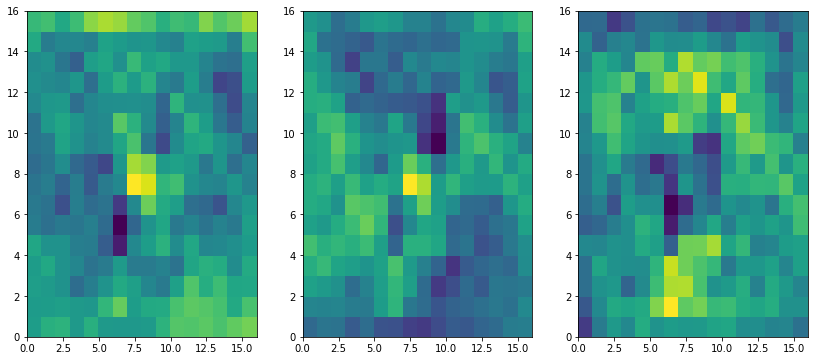

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
for i in range(3):
    axs[i].pcolormesh(vit_model.vit.embeddings.patch_embeddings.projection.weight.data.cpu().detach().numpy()[0, i])
plt.show()

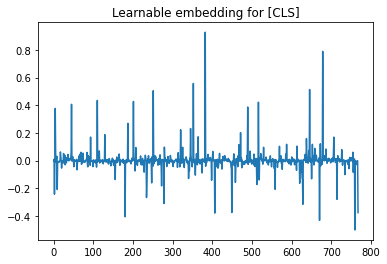

In [ ]:
plt.title("Learnable embedding for [CLS]")
plt.plot(vit_model.vit.embeddings.cls_token[0, 0].cpu().detach().numpy())
plt.show()

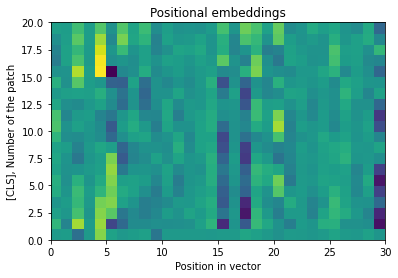

In [ ]:
plt.title('Positional embeddings')
plt.ylabel('[CLS], Number of the patch')
plt.xlabel('Position in vector')
plt.pcolormesh(vit_model.vit.embeddings.position_embeddings[0].cpu().detach().numpy()[:20, :30])
plt.show()

In [ ]:
im = train_data[77][0]
inputs = feature_extractor(train_data[0][0])


att_mat = vit_model(torch.FloatTensor(inputs['pixel_values']), output_attentions=True)['attentions']
att_mat = torch.stack(att_mat).squeeze(1)
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

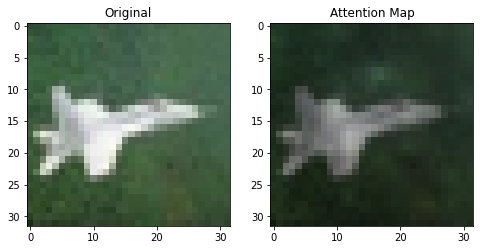

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))

ax1.set_title('Original')
ax2.set_title('Attention Map')
ax1.imshow(im)
ax2.imshow(result)